# FORESEE Models: Dark Photon

## Load Libraries 

In [1]:
%load_ext autoreload 
%autoreload 2



In [2]:
import numpy as np
import sys
import os
src_path = "../../"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model
from matplotlib import pyplot as plt

/home/makelat/work/FORESEE/Models/DarkPhoton/../../src/foresee.py:573: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def boostlist(arr_particle, arr_boost):


## 1. Specifying the Model

The dark photon $A′$ is a new massive vector boson, which could, for example, be the gauge boson of a broken abelian gauge group in a hidden sector. Since the dark photon has the same quantum numbers as the photon of the SM, thw two states can kinetically mix. This effectively introduces couplings of the dark photon to all charged SM fermions. The phenomenology of the dark photon can then be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = \frac{1}{2} \color{red}{m_{A'}}^2 A'^2  - \color{red}{\epsilon} e \sum \bar f \gamma^\mu f A'_\mu
\end{equation}

with the dark photon mass $m_{A'}$ and the kinetic mixing parameter $\epsilon$ as free parameters. 

In [3]:
# energy = "100"
energy = "13.6"
modelname="DarkPhoton"
model = Model(modelname, path="./")

**Production:** If the dark photon is sufficiently light, it is primarily produced in the decay of pseudoscalar mesons $\pi^0$, $\eta$ and $\eta' \to \gamma A'$. The branching fractions for the leading channels are 

\begin{equation}
    \text{BR}(\pi^0 \to A' \gamma) = 2 \epsilon^2 \times\text{BR}(\pi^0 \to \gamma\gamma) \times \left(1-m_{A'}^2/m_\pi^2\right)^3
    \quad\quad\text{and}\quad\quad
    \text{BR}(\eta \to A' \gamma) = 2 \epsilon^2 \times\text{BR}(\eta \to \gamma\gamma) \times \left(1-m_{A'}^2/m_\eta^2\right)^3
\end{equation}

In the following, we model the production using `EPOSLHC`, `SIBYLL` and `QGSJET`. 

In [4]:
model.add_production_2bodydecay(
    pid0 = "111",
    pid1 = "22",
    br = "2.*0.99 * coupling**2 * pow(1.-pow(mass/self.masses('pid0'),2),3)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
    nsample = 100,
)

In [5]:
model.add_production_2bodydecay(
    pid0 = "221",
    pid1 = "22",
    br = "2.*0.39 * coupling**2 * pow(1.-pow(mass/self.masses('pid0'),2),3)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
    nsample = 100, 
)

We can also produce the dark photon via its resonant mixing with the QCD vector mesons, in particular the $\omega$, $\rho$ and $\phi$ mesons. Following [1810.01879](https://arxiv.org/pdf/1810.01879.pdf), we can write 

\begin{equation}
    \sigma(A') = \theta_V^2 \  \sigma(V)
    \quad\quad\text{with}\quad\quad
    \theta_V = \frac{\epsilon e}{g_V}  \frac{m_V^2}{m_{A'}^2 - m_V^2 + i m_V \Gamma_V}
\end{equation}

Here $g_\omega = 17$, $g_\rho=5$ and $g_\phi=-12.88$. In the following, we focus on the $\rho$, which provides the leading contribution. 

In [6]:
model.add_production_mixing(
    pid = "113",
    mixing = "coupling * 0.3/5. * self.masses('pid')**2/abs(mass**2-self.masses('pid')**2+self.masses('pid')*self.widths('pid')*1j)",
    generator = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
)

Dark photons can also be produced via dark Bremsstrahlung, so coherent radiation off a proton in processes such as $p p \to p p A'$. The spectra for LLPs have been exbtained following the description in [1708.09389](https://arxiv.org/abs/1708.09389) and are provided in the `files/direct` directory. As the FWW apprixmation loose validaty at high pT, we impose a cut on the pT of the dark photon and study the associated uncertainy by varing that cut as `0.5`, `1`, `2` GeV.


In [7]:
masses_brem = [ 
    0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
    0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
    0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
    0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
    0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
    0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
    0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
    1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
    2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]

model.add_production_direct(
    label = "Brem",
    energy = energy,
    condition = ["p.pt<1", "p.pt<2", "p.pt<0.5", "p.pt<1"],
    coupling_ref=1,
    masses = masses_brem,
)

At high masses, the production of dark photons is dominated by Drell-Yan production, so quark-anti-quark fusion $q q \to A' + X$. Here we use the dark photon spectra obtained in [1810.01879](https://arxiv.org/pdf/1810.01879.pdf) using MadGraph plus Pythia, which are provided in the `files/direct` directory. 

In [8]:
#masses_dy = [1.5849, 1.7783, 1.9953,2.2387, 2.5119, 2.8184, 3.1623, 3.9811, 5.0119, 6.3096, 7.9433, 10.]
#model.add_production_direct(
#    label = "DY",
#    energy = energy,
#    coupling_ref=1,
#    masses = masses_dy,
#    condition='True',
#)

**Decay:** Dark photons can decay into all kinematically accessible light charged states, with a decay width proportional to $\epsilon^2$. Here we use the lifetime and the decay branching fractions as presented in [1801.04847](https://arxiv.org/abs/1801.04847) for the DarkCast tool. 

In [9]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
)

decay_modes = ["e_e", "mu_mu", "pi+_pi-", "pi0_gamma", "pi+_pi-_pi0", "K_K"] 
model.set_br_1d(
    modes = decay_modes,
    finalstates=[[11,-11], [13,-13], [221,-211], [111,22], None, [321,-321]],
    filenames=["model/br/"+mode+".txt" for mode in decay_modes],
)

We can now initiate FORESEE with the model that we just created. 

In [10]:
foresee = Foresee(path=src_path)
foresee.set_model(model=model)

## 2. Event Generation

In the following, we want to study one specific benchmark point with $m_{A'}=50$ MeV and $\epsilon=3\cdot 10^{-5}$ and export events as a HEPMC file. 

In [11]:
mass, coupling, = 0.05, 3e-5

First, we will produce the corresponding flux for this mass and a reference coupling $\epsilon_{ref}=1$. 

save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_Pythia8-Forward_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_Pythia8-Forward_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_EPOSLHC_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_SIBYLL_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_QGSJET_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_Pythia8-Forward_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.05.npy
sa

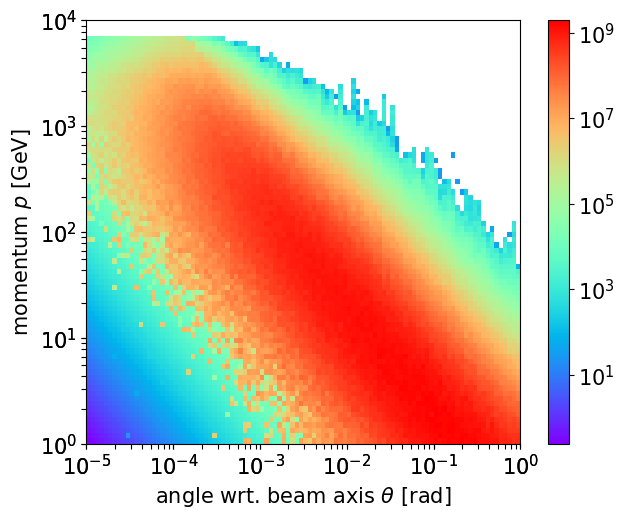

CPU times: user 3.99 s, sys: 341 ms, total: 4.33 s
Wall time: 4.03 s


In [12]:
%%time

plot=foresee.get_llp_spectrum(mass=mass, coupling=1, do_plot=True)
plot.savefig("Spectrum_"+modelname+".pdf")
plot.show()

Next, let us define the configuration of the detector (in terms of position, size and luminosity). Here we choose FASER during 2022/2023. 

In [13]:
foresee.set_detector(
    distance=620, 
#     selection="np.sqrt(x.x**2 + (x.y+0.065)**2)<.1",
    selection="np.sqrt((x.x)**2 + (x.y)**2)<10",    
    length=10, 
    luminosity=3000, 
)

For our benchmark point, let us now look at how many particle decay inside the decay volume. We also export 1000 unweighted events as a HEPMC file. 

In [14]:
%%time

setupnames = ['EPOSLHC_pT=1', 'SIBYLL_pT=2', 'QGSJET_pT=0.5', 'PYTHIA_pT=1']
modes = {'111': ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'], 
         '221':['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'], 
         "Brem": ["p.pt<1", "p.pt<2", "p.pt<0.5", "p.pt<1"]}

# setupnames = ['EPOSLHC_pT=1']
# modes = {'111': ['EPOSLHC'], 
#          '221':['EPOSLHC'], 
#          "Brem": ["p.pt<1"]}

momenta, weights, _ = foresee.write_events(
    mass = mass, 
    coupling = coupling, 
    energy = energy, 
    numberevent = 1000,
    filename = "model/events/test.hepmc", 
    return_data = True,
    weightnames=setupnames,
    modes=modes,
)

for isetup, setup in enumerate(setupnames):
    print("Expected number of events for "+setup+":", round(sum(weights[:,isetup]),3))

Expected number of events for EPOSLHC_pT=1: 1036.128
Expected number of events for SIBYLL_pT=2: 1551.466
Expected number of events for QGSJET_pT=0.5: 483.939
Expected number of events for PYTHIA_pT=1: 1036.241
CPU times: user 9.87 s, sys: 638 ms, total: 10.5 s
Wall time: 10.5 s


Let us plot the resulting energy distribution

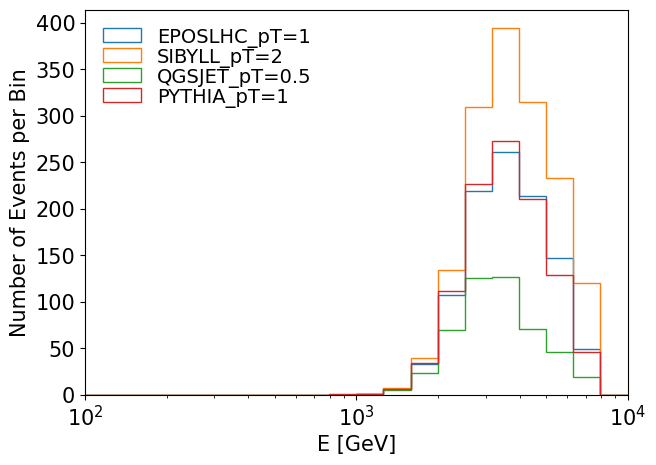

CPU times: user 250 ms, sys: 239 ms, total: 489 ms
Wall time: 192 ms


In [15]:
%%time

fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
energies = [p.e for p in momenta], 
for isetup, setup in enumerate(setupnames):
    ax.hist(energies, weights=weights[:,isetup], bins=np.logspace(2,4, 20+1), histtype='step', label=setup) 
ax.set_xscale("log")
ax.set_xlim(1e2,1e4) 
ax.set_xlabel("E [GeV]") 
ax.set_ylabel("Number of Events per Bin") 
ax.legend(frameon=False, labelspacing=0, fontsize=14, loc='upper left')
plt.savefig("E_distribution_"+modelname+".pdf")
plt.show()

## 3. Sensitivity Reach

In the following, we will obtain the projected sensitivity for the LLP model. For this, we first define a grid of couplings and masses, and then produce the corresponding fluxes. 

In [16]:
%%time

masses=[round(x,5) for x in np.logspace(-2,0.2,22+1)]
couplings = np.logspace(-9,-3,121) 

for mass in masses: foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_Pythia8-Forward_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_Pythia8-Forward_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_Pythia8-Forward_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.01.npy
sa

save data to file: ./model/LLP_spectra/13.6TeV_111_EPOSLHC_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_SIBYLL_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_QGSJET_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_111_Pythia8-Forward_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_Pythia8-Forward_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_EPOSLHC_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_SIBYLL_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_QGSJET_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_Pythia8-Forward_m_0.05012.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.05012.npy
save data to file: ./model/LLP_sp

save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<2_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<0.5_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.25119.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_EPOSLHC_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_SIBYLL_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_QGSJET_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_221_Pythia8-Forward_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_EPOSLHC_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_SIBYLL_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_QGSJET_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_113_Pythia8-Forward_m_0.31623.npy
save data to file: ./model/LLP_spectra/13.6TeV_Brem_p.pt<1_m_0.31623.npy
save data to file: ./model/LLP_spectr

We can now plot the `production rate vs mass` using the `foresee.plot_production()` function.

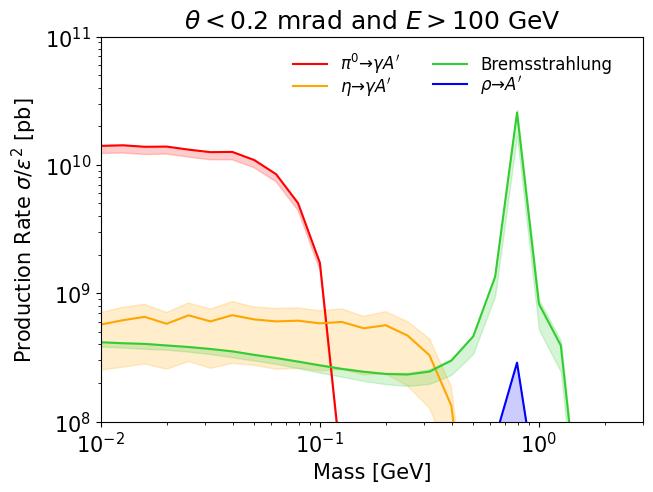

CPU times: user 15.5 s, sys: 236 ms, total: 15.7 s
Wall time: 15.5 s


In [17]:
%%time

productions=[
    {"channels": ["111"] , "color": "red"      , "label": r"$\pi^0 \to \gamma A'$", "generators": ["EPOSLHC","QGSJET","SIBYLL","Pythia8-Forward"]  },
    {"channels": ["221"] , "color": "orange"   , "label": r"$\eta \to \gamma A'$" , "generators": ["EPOSLHC","QGSJET","SIBYLL","Pythia8-Forward"]  },
    {"channels": ["Brem"], "color": "limegreen", "label": r"Bremsstrahlung"       , "generators": ["p.pt<1" ,"p.pt<2","p.pt<0.5","p.pt<1"]},
    {"channels": ["113"] , "color": "blue"     , "label": r"$\rho \to A'$"        , "generators": ["EPOSLHC","QGSJET","SIBYLL","Pythia8-Forward"]  },
]

plot=foresee.plot_production(
    masses = masses,
    productions = productions,
    energy=energy,
    condition="logth<-3.7 and logp>2",  
    xlims=[0.01,3],ylims=[1e8,1e11],
    xlabel=r"Mass [GeV]",
    ylabel=r"Production Rate $\sigma/\epsilon^2$ [pb]",
    title=r"$\theta < 0.2$ mrad and $E > 100$ GeV",
    legendloc=(0.97,1),
    fs_label=12,
    ncol=2,
)

plot.savefig("photon_production_channels_E100.pdf")
plot.show()

Let us now scan over various masses and couplings, and record the resulting number of evets. Note that here we again consider the FASER configuration, which we set up before.

In [18]:
%%time

#get reach  
list_nevents = {label:[] for label in setupnames}
for mass in masses:
    couplings, _, nevents, _, _  = foresee.get_events(mass=mass, energy=energy, couplings = couplings,modes=modes)
    for i,label in enumerate(setupnames): list_nevents[label].append(nevents.T[i])  
        
#save results
configuration='default'
for label in setupnames: 
    result = np.array([masses,couplings,list_nevents[label]], dtype='object')
    np.save("model/results/"+energy+"TeV_"+configuration+"_"+label+".npy",result)

CPU times: user 2min 39s, sys: 863 ms, total: 2min 40s
Wall time: 2min 40s


We can now plot the results. For this, we first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [19]:
setups = [ 
    ["13.6TeV_default_EPOSLHC_pT=1.npy",  "EPOS / pT=1"    , "red"        ,  "solid"  , 0., 3],
    ["13.6TeV_default_SIBYLL_pT=2.npy" ,  "SYBILL / pT=2"  , "orange"    ,  "solid"  , 0., 3],
    ["13.6TeV_default_QGSJET_pT=0.5.npy" ,"QGSJET / pT=0.5", "magenta"     ,  "solid"  , 0., 3],
    ["13.6TeV_default_PYTHIA_pT=1.npy",  "PYTHIA / pT=1"    , "pink"        ,  "solid"  , 0., 3],
]

Then we specify all the existing bounds, separating the bounds obtained by experimental collaborations and theory recasts.

In [20]:
bounds2 = [ 
#    ["bounds_FASER-27invfb.txt", "FASER", 3.5e-2, 1.7e-5, -30], 
    #["bounds_E137.txt",  "E137",  0.015, 9.00e-8, 0  ],
    ["bounds_NuCal.txt", "NuCal", 0.101, 3.00e-6, -20],
    ["bounds_CHARM.txt", "CHARM", 0.101, 1.0e-6, -20 ],
    ["bounds_Orsay.txt", "Orsay", 3.8e-2, 2.0e-6, 0],
    ["bounds_E141.txt",  "E141",  0.021, 1.0e-4, 0 ],
]
bounds = [ 
    ["bounds_NA62mumu.txt", r"NA62 - $\mu\mu$", 0.220, 7.0e-7, 0],    
    ["bounds_FASER-27invfb.txt", "FASER", 3.5e-2, 1.8e-5, -30],    
    ["bounds_NA48.txt",  "NA48",  0.015, 1.20e-3, 0  ],
    ["bounds_LHCb1.txt", "LHCb",  0.220, 7.00e-5, 0  ],
    ["bounds_LHCb2.txt",  None  , 0    , 0      , 0  ],
    ["bounds_LHCb3.txt",  None  , 0    , 0      , 0  ],
    ["bounds_NA64.txt",  "NA64",  0.015, 2.40e-4, -30],
    ["bounds_BaBar.txt", "BaBar", 0.320, 1.20e-3, 0  ],
    ["bounds_A1.txt",    "A1",    0.100, 1.20e-3, 0  ],
    #["bounds_KLOE.txt",  "KLOE",  0.620, 1.40e-3, 0  ],
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [21]:
projections = [
    #["limits_SeaQuest.txt",       "teal",     "SeaQuest", 0.300, 5.0e-6, -30  ],
    ["limits_NA62.txt",           "dodgerblue",   "NA62"    , 0.131, 4.5e-6, -20  ],
    #["limits_SHiP.txt",           "cyan",         "SHiP"    , 0.150, 1.4e-5, -30  ],
    #["limits_HPS-prompt.txt",     "deepskyblue",  "HPS"     , 0.050, 1.4*10**-4, 0  ],
    #["limits_HPS-displaced.txt",  "deepskyblue",  None      , 0.050, 1.4*10**-4, 0  ],
    ["limits_Belle2.txt",         "blue",         "Belle2"  , 0.050, 2.4*10**-4, 0  ],
    ["limits_LHCb.txt",           "dodgerblue",   "LHCb"    , 0.135, 2.8*10**-4, 0  ],
    ["limits_LHCb-mumu1.txt",     "dodgerblue",   None      , 0    , 0         , 0  ],
    ["limits_LHCb-mumu2.txt",     "dodgerblue",   None      , 0    , 0         , 0  ],
]

We also want to show the branching fractions for some of the channels (name of file in model/br directory, color, line style, label, x-position, y-position)  

In [22]:
branchings = [
    ["e_e"         , "red"          , "solid" , r"ee"               , 0.050, 0.60],
    ["mu_mu"       , "orange"       , "solid" , r"$\mu\mu$"         , 0.170, 0.10],
    ["pi+_pi-"     , "blue"         , "solid" , r"$\pi^+\pi^-$"     , 0.225, 0.05],
    ["pi0_gamma"   , "dodgerblue"   , "solid" , r"$\pi^0\gamma$"    , 0.580, 0.02],
    ["pi+_pi-_pi0" , "cyan"         , "solid" , r"$\pi^0\pi^+\pi^-$", 0.389, 0.05],
    ["K_K"         , "green"        , "solid" , r"$KK$"             , 1.150, 0.105], 
]

Finally, we can plot everything using `foresee.plot_reach()`. Here we also add the dark matter relict target line obtained in [2105.07077](https://arxiv.org/abs/2105.07077).

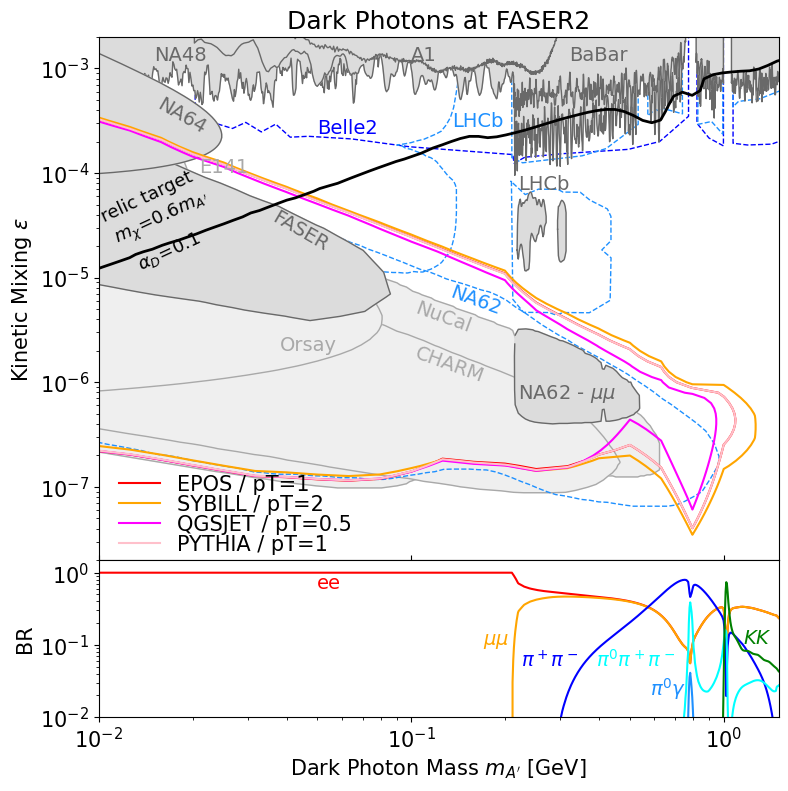

In [23]:
plot, ax, ax2 = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    bounds2=bounds2,
    projections=projections,
    branchings=branchings,
    title="Dark Photons at FASER2", 
    xlims = [0.01,1.5], 
    ylims=[2e-8,0.002],
    xlabel=r"Dark Photon Mass $m_{A'}$ [GeV]", 
    ylabel=r"Kinetic Mixing $\epsilon$",
#     legendloc=(1.03,0.72),
    legendloc=(0.4,0.2),
    figsize=(8,8),
)

data = foresee.readfile("model/lines/scalar_DM_Oh2_intermediate_eps_vs_mAprime.txt")
ax.plot(data.T[0], data.T[1], color="k", lw=2)
ax.text(0.010, 3.40*10**-5, "relic target",  fontsize=13,color="k",rotation=25)
ax.text(0.011, 2.15*10**-5, r"$m_\chi\!=\!0.6 m_{A'}$",fontsize=13,color="k",rotation=25)
ax.text(0.013, 1.20*10**-5, r"$\alpha_D\!=\!0.1$",fontsize=13,color="k",rotation=25)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("Reach_"+modelname+".pdf")
plot.show()